# CS131 Final Project: Fingerprint Validation Using Canny Edge Detection
#### Bradley Hu   

For my final project, I am examining the effectiveness of edge detection in validating fingerprints under varying finger skin conditions. Since different levels of moisture in the finger results in very different scan prints (see below), I am interested in exploring the potential of Canny Edge Detection as an application / potential remedy in validating fingerprints under these diverging conditions.    

In [3]:
# Setup
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from time import time
from skimage import io
from skimage.metrics import structural_similarity as ssim
from IPython.display import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


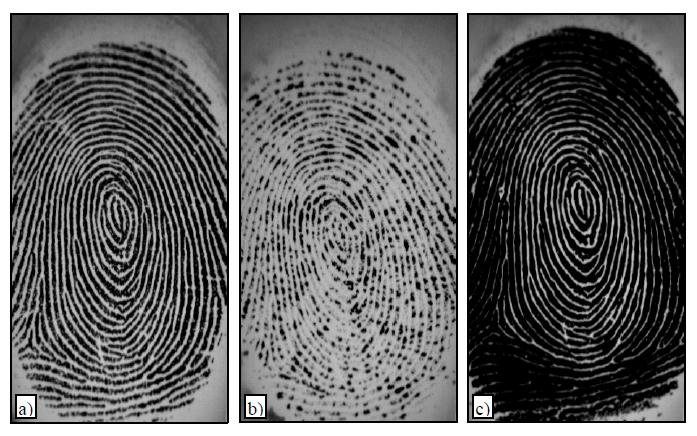

In [4]:
Image('fingerprints_under_diff_conditions.png')

Three fingerprints of the same finger with different skin conditions acquired with an optical FTIR scanner: a) normal, b) dry, c) wet [from Maltoni et al., Handbook of Fingerprint Recognition (2nd Ed.) (2009)] [1]

### Smoothing

We first smooth the input image to reduce noise by convolving it with a Gaussian kernel.

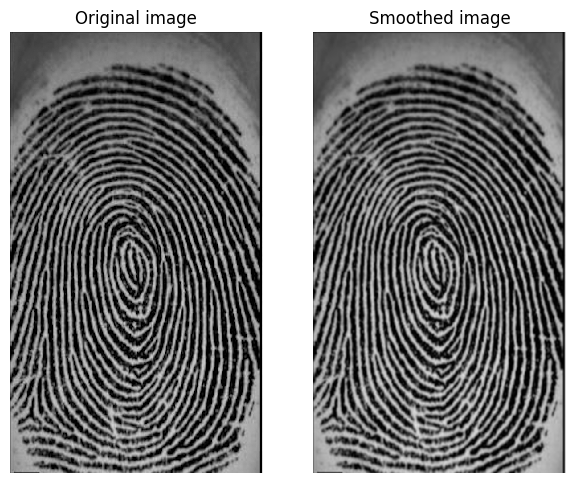

In [5]:
from utils import conv, gaussian_kernel

kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('normal_fingerprint.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

### Finding gradients
We'll now compute the gradient magnitude and direction.

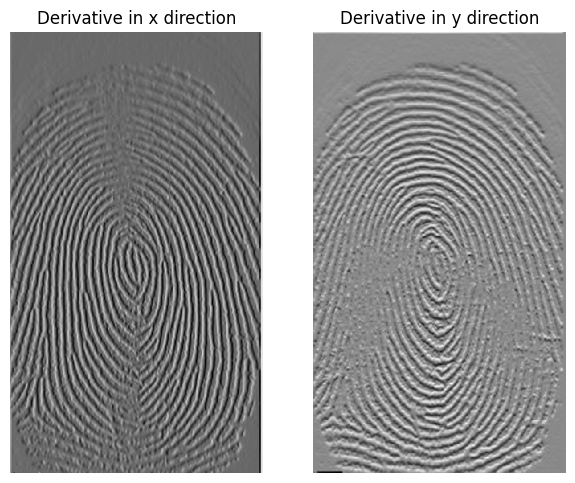

In [7]:
from utils import partial_x, partial_y

# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,4,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

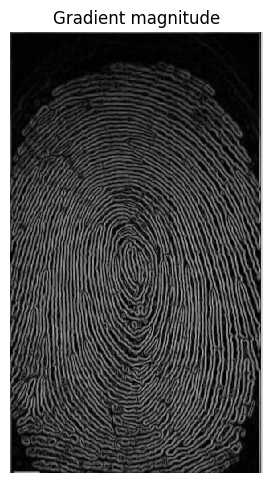

In [10]:
from utils import gradient

G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.subplot(1, 4, 1)
plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### Non-maximum suppression
We see that the edges extracted from the gradient of the smoothed image are quite thick and blurry. We now use non-maximum suppression to convert the "blurred" edges into "sharp" edges by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

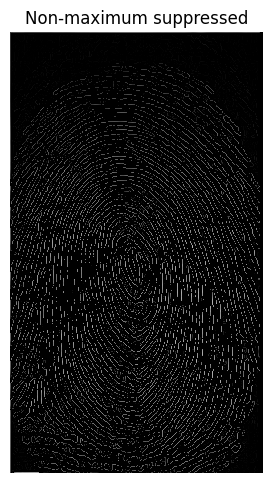

In [11]:
from utils import non_maximum_suppression

nms = non_maximum_suppression(G, theta)

plt.subplot(1, 4, 1)
plt.imshow(nms)
plt.axis('off')
plt.title('Non-maximum suppressed')

plt.show()

### Double Thresholding

The edge-pixels remaining after the non-maximum suppression step are still marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations. 

We can discern between these using double thresholding, preserving only edges within a certain value.
- Edge pixels stronger than the high threshold are marked as strong.
- Edge pixels weaker than the low threshold are suppressed.
- Edge pixels between the two thresholds are marked as weak.

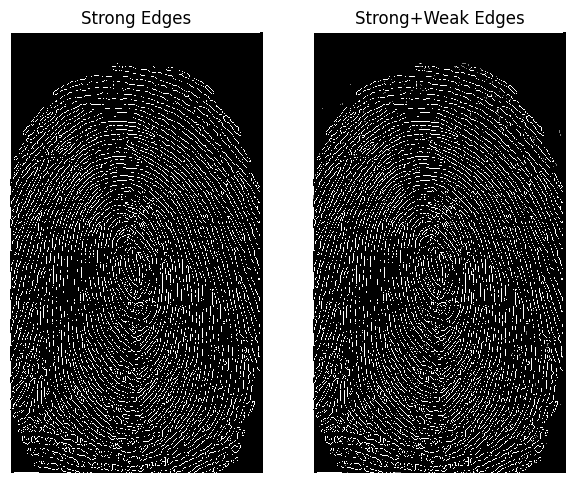

In [12]:
from utils import double_thresholding

low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,4,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### Edge tracking

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. We can consider its neighbors iteratively then declare it an 'edge pixel' if it is connected to a 'strong edge pixel' directly or via pixels between Low and High, since weak edges due to true edges are much more likely to be connected directly to strong edges.

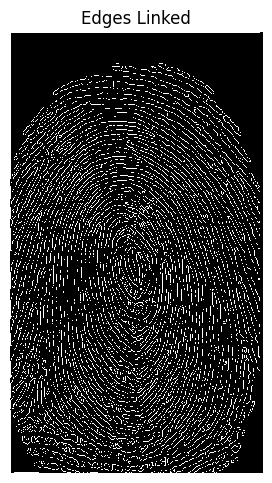

In [15]:
from utils import get_neighbors, link_edges

edges = link_edges(strong_edges, weak_edges)

plt.subplot(1, 4, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges Linked')

plt.show()

##  Putting it all together: Canny Edge Detector
We can now assemble our canny edge detector using all of the components we modeled above. Our function, **`canny`**, takes in an image, and a set of hyperparamaters for edge detection.

Our default hyperparamaters for the intitial exploration:
- kernel_size = 5
- sigma = 1.4
- high = 0.03
- low = 0.02

/var/folders/h0/fvy3lnlx5qngzmyg2klxzs9m0000gp/T/ipykernel_37636/4213782741.py:10: UserWarning: normal_edges.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('normal_edges.png', edges)


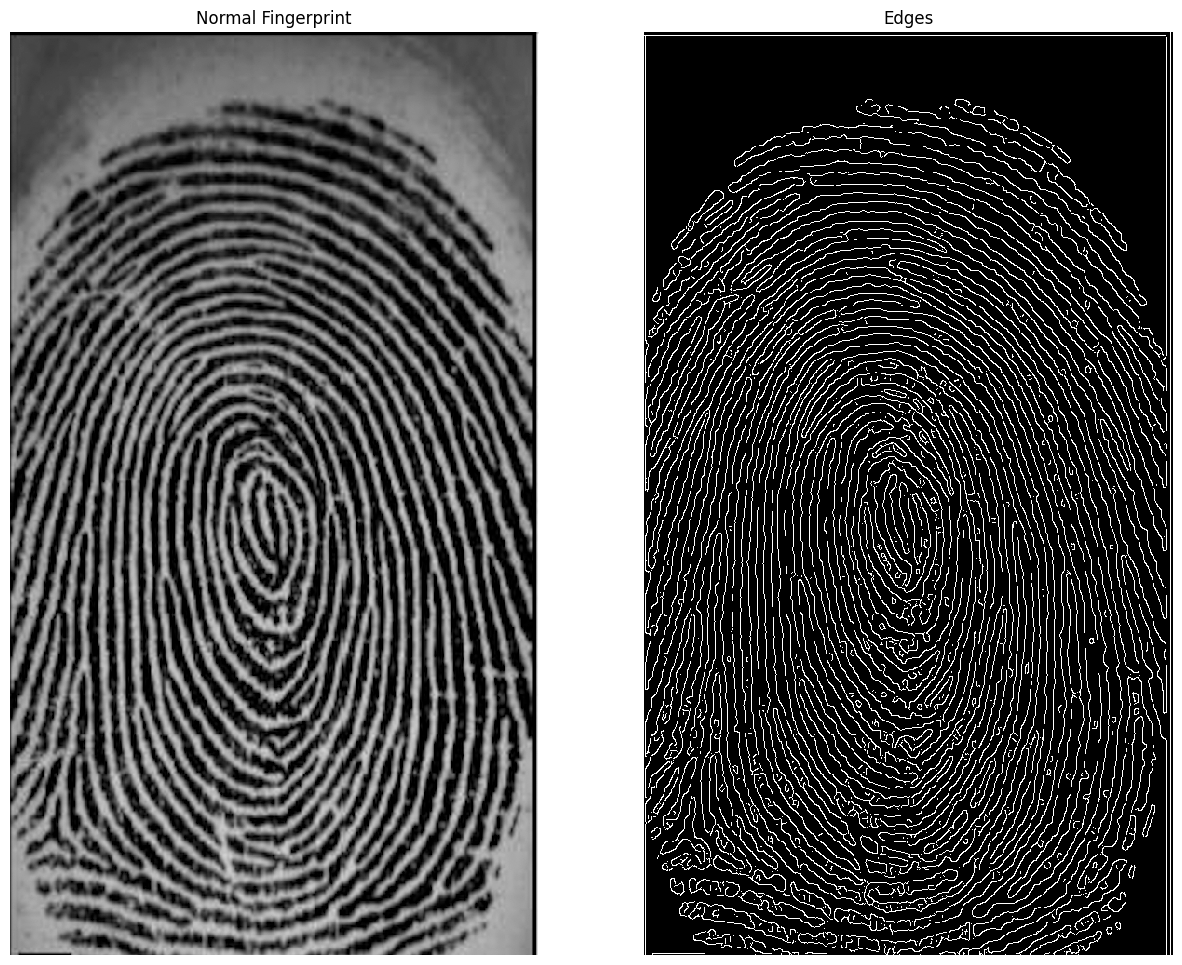

In [17]:
from utils import canny

# Load image
img = io.imread('normal_fingerprint.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

# Save the edges image
io.imsave('normal_edges.png', edges)

plt.subplot(1, 2, 2)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')

plt.subplot(1, 2, 1)
input_image = io.imread('normal_fingerprint.png', as_gray=True)
plt.imshow(input_image)
plt.axis('off')
plt.title('Normal Fingerprint')


plt.show()

### Dry Fingerprint

/var/folders/h0/fvy3lnlx5qngzmyg2klxzs9m0000gp/T/ipykernel_27627/2116469786.py:9: UserWarning: dry_edges.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('dry_edges.png', edges)


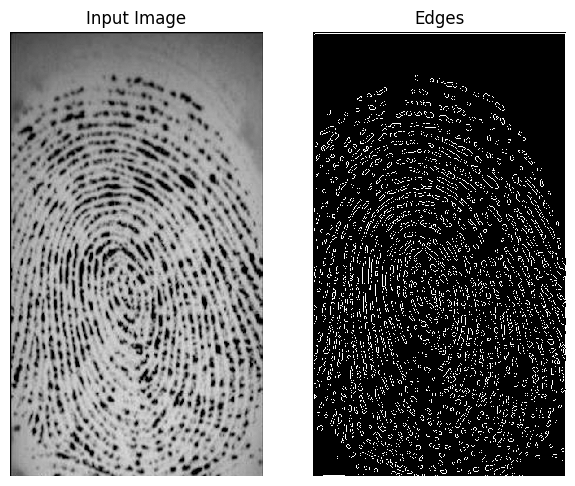

In [91]:
from utils import canny

# Load image
img = io.imread('dry_fingerprint.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

# Save the edges image
io.imsave('dry_edges.png', edges)

plt.subplot(1, 4, 2)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.show()

### Wet Fingerprint


/var/folders/h0/fvy3lnlx5qngzmyg2klxzs9m0000gp/T/ipykernel_27627/764079530.py:9: UserWarning: wet_edges.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('wet_edges.png', edges)


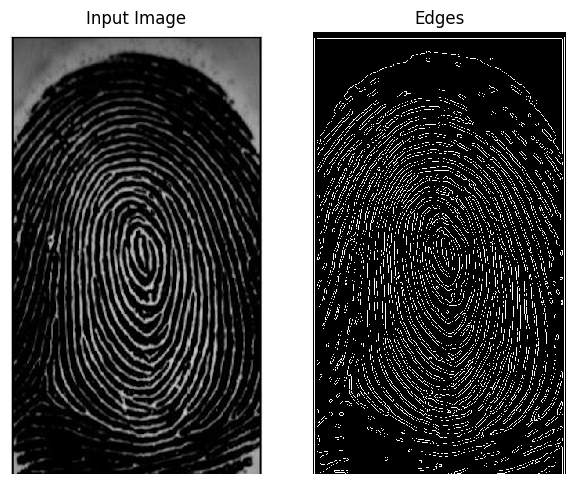

In [92]:
from utils import canny

# Load image
img = io.imread('wet_fingerprint.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

# Save the edges image
io.imsave('wet_edges.png', edges)

plt.subplot(1, 4, 2)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.show()

### Optimizing the Model

I then experimented with different hyperparameters to find a combination that produces the strongest representation of edges for each fingerprint condition (dry and wet). Since it would have been very verbose to copy and paste the same model over and over, here are the optimal setups I found.

To address the problem of long edges broken into short segments, we should decrease the lowerthreshold so that the lost edges are accepted.

To address the problem of spurious edges, we should increase the higher threshold to reduce falsepositives.

#### Dry Fingerprint

In the case of a dry fingerprint, we have a less strongly defined print, leading to edges being lost in our intial model. The main adjustment is to connect these broken segments by decreasing the lower threshold; we also need to increase the higher threshold as spurious edges occur from some of the textures of the surrounding skin being the same edge strength as those of the more faint fingeprint ridges.

/var/folders/h0/fvy3lnlx5qngzmyg2klxzs9m0000gp/T/ipykernel_37636/2892243385.py:10: UserWarning: dry_edges_optimized.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('dry_edges_optimized.png', edges)


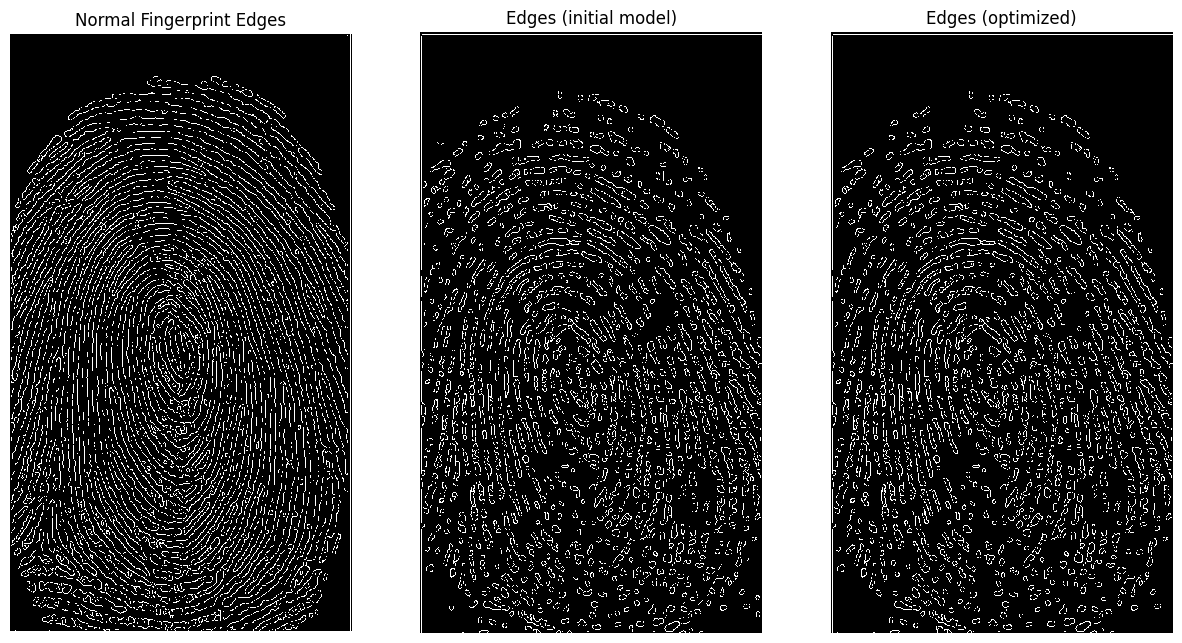

In [47]:
from utils import canny

# Load image
img = io.imread('dry_fingerprint.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.04, low=0.000000001)

# Save the edges image
io.imsave('dry_edges_optimized.png', edges)

plt.subplot(1, 3, 3)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges (optimized)')

plt.subplot(1, 3, 2)
plt.imshow(mpimg.imread('dry_edges.png'))
plt.axis('off')
plt.title('Edges (initial model)')

plt.subplot(1, 3, 1)
plt.imshow(mpimg.imread('normal_edges.png'))
plt.axis('off')
plt.title('Normal Fingerprint Edges')

plt.show()

#### Wet Fingerprint

In the case of a wet fingerprint, we still have disconnected edges, but in addition edges that are too prominent and leading to spurious edges in our edge detection. I attempted to adjust by decreasing the lower threshold again for disconnected edges, and also marginally increasing the high threshold, kernel size, and sigma to decrease the contrast intensity of the initial image to account for spurious edges. 

/var/folders/h0/fvy3lnlx5qngzmyg2klxzs9m0000gp/T/ipykernel_34511/1370963388.py:9: UserWarning: wet_edges_optimized.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('wet_edges_optimized.png', edges)


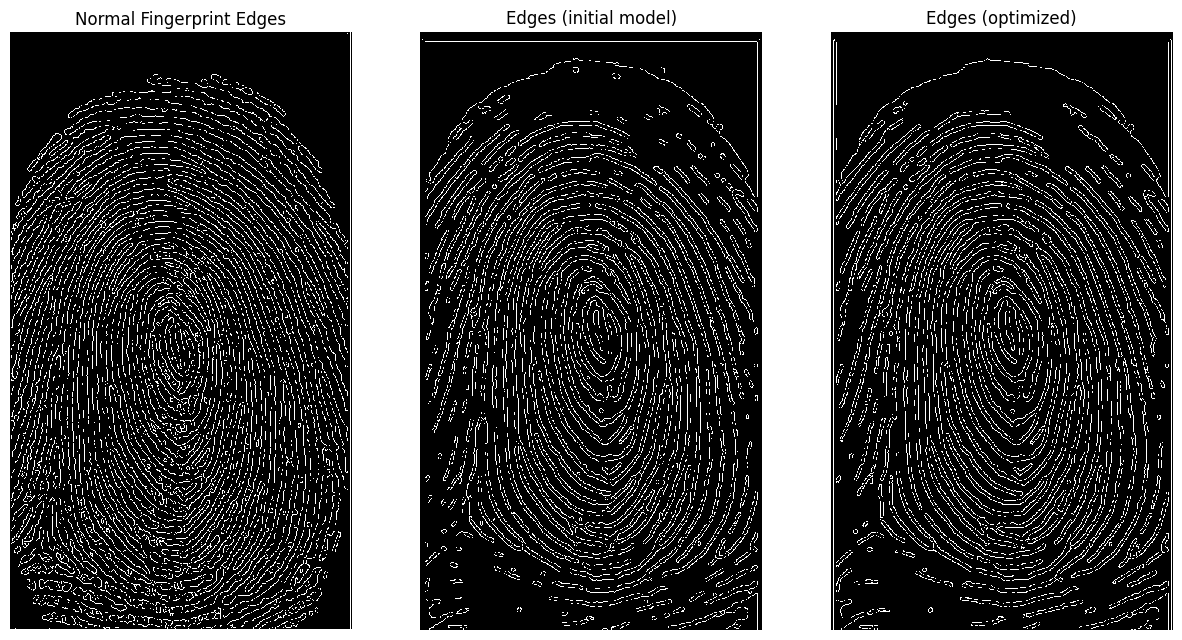

In [11]:
from utils import canny

# Load image
img = io.imread('wet_fingerprint.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=6, sigma=1.6, high=0.04, low=0.000001)

# Save the edges image
io.imsave('wet_edges_optimized.png', edges)

plt.subplot(1, 3, 3)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges (optimized)')

plt.subplot(1, 3, 2)
plt.imshow(mpimg.imread('wet_edges.png'))
plt.axis('off')
plt.title('Edges (initial model)')

plt.subplot(1, 3, 1)
plt.imshow(mpimg.imread('normal_edges.png'))
plt.axis('off')
plt.title('Normal Fingerprint Edges')

plt.show()

### Testing Edge Detected Fingerprints

We are now ready to test our edge detected results against our reference fingerprint edges. More specifically, we are interested in examining whether these edge detected models are more effective for fingerprint validation across different fingerprint conditions than the non-edge-detected model.

Our function **`compare_images`**, uses Structural Similarity Index (SSIM) to take in two images and output a similarity score.

In choosing a similarity algorithm, I also considered Mean Squared Error (MSE), but ultimately SSIM is a more robust model because:
- SSIM attempts to model the perceived change in the structural information of the image, whereas MSE is actually estimating the perceived errors.
- SSIM compares two windows (i.e. small sub-samples) rather than the entire image as in MSE. Doing this leads to a more robust approach that is able to account for changes in the structure of the image, rather than just the perceived change.

[src: https://pyimagesearch.com/2014/09/15/python-compare-two-images/]

#### Validating with Raw Fingerprint

In [21]:
from utils import compare_images

# load the images - reference, dry fingerprint, wet fingerprint
normal = cv2.imread("normal_fingerprint.png")
dry = cv2.imread("dry_fingerprint.png")
wet = cv2.imread("wet_fingerprint.png")

# convert the images to grayscale
normal = cv2.cvtColor(normal, cv2.COLOR_BGR2GRAY)
dry = cv2.cvtColor(dry, cv2.COLOR_BGR2GRAY)
wet = cv2.cvtColor(wet, cv2.COLOR_BGR2GRAY)

# resize the images to be the same size as reference image
width, height = int(normal.shape[1]), int(normal.shape[0])
dry = cv2.resize(dry, (width, height)) 
wet = cv2.resize(wet, (width, height)) 

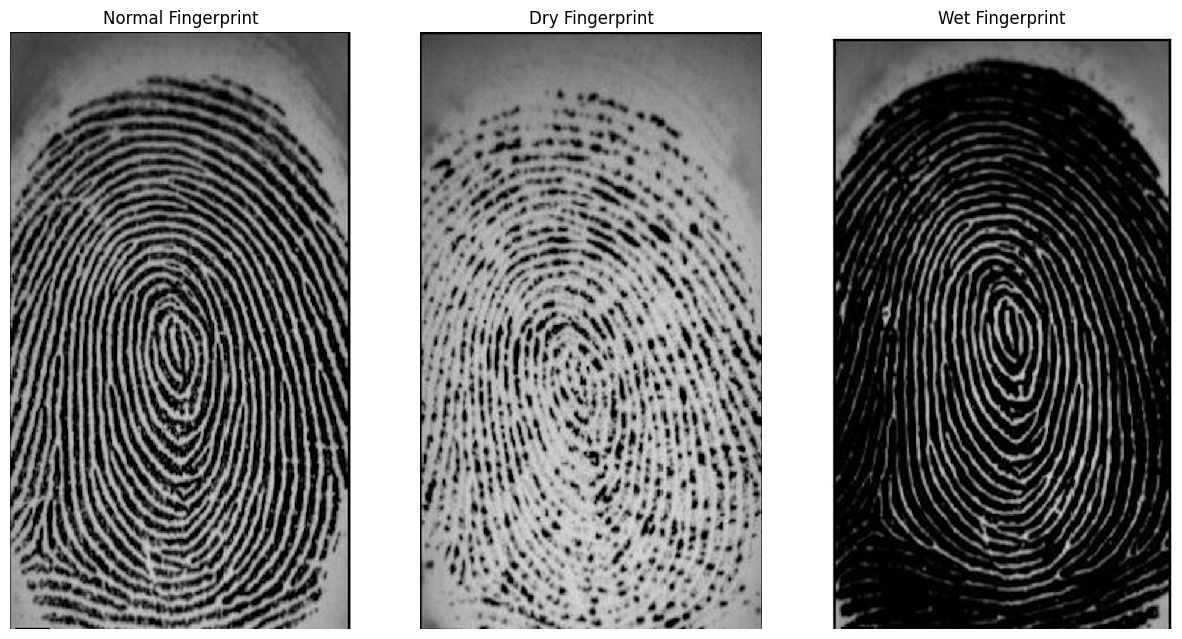

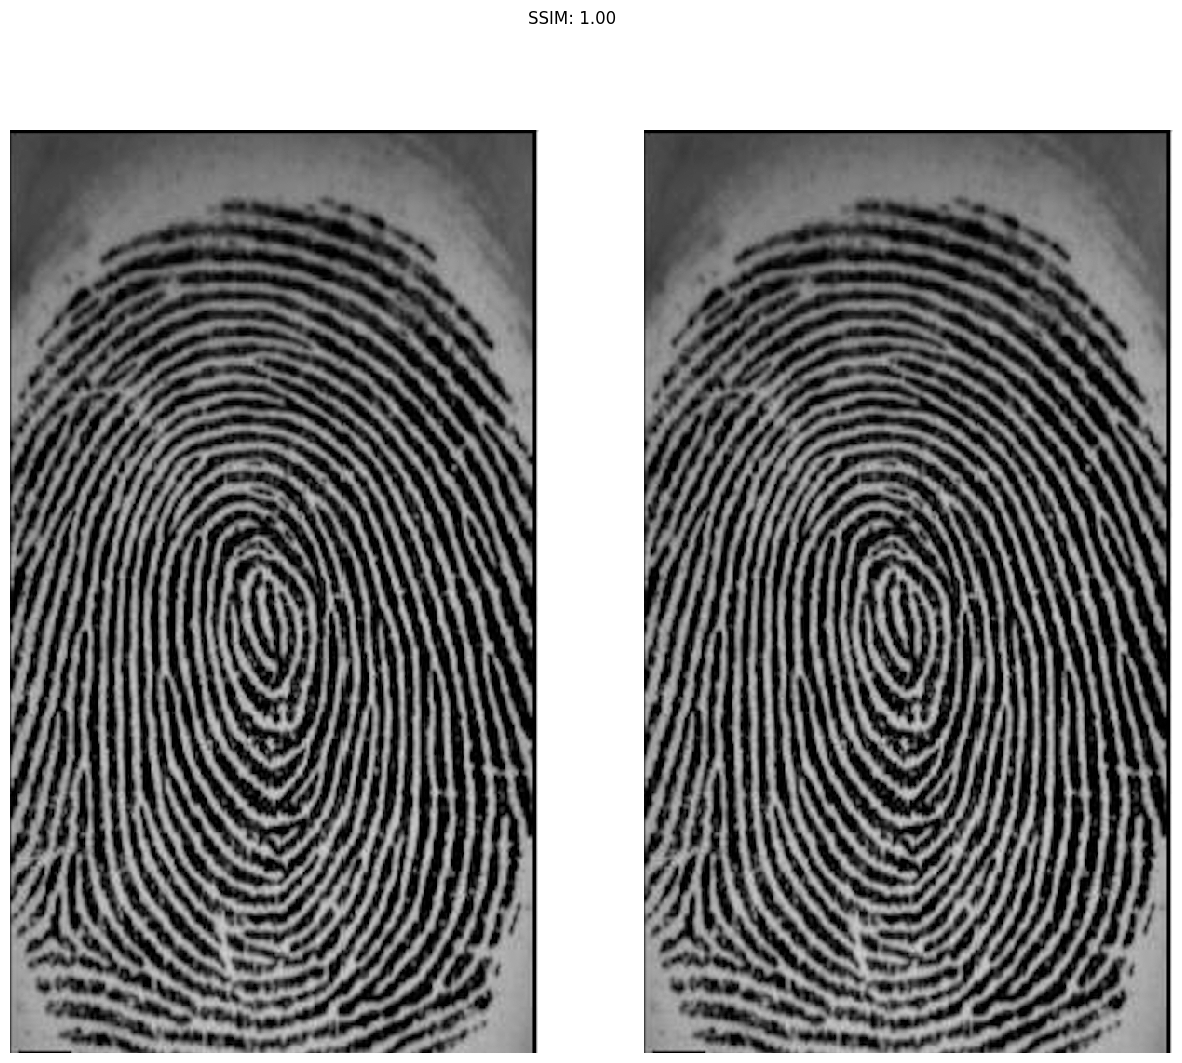

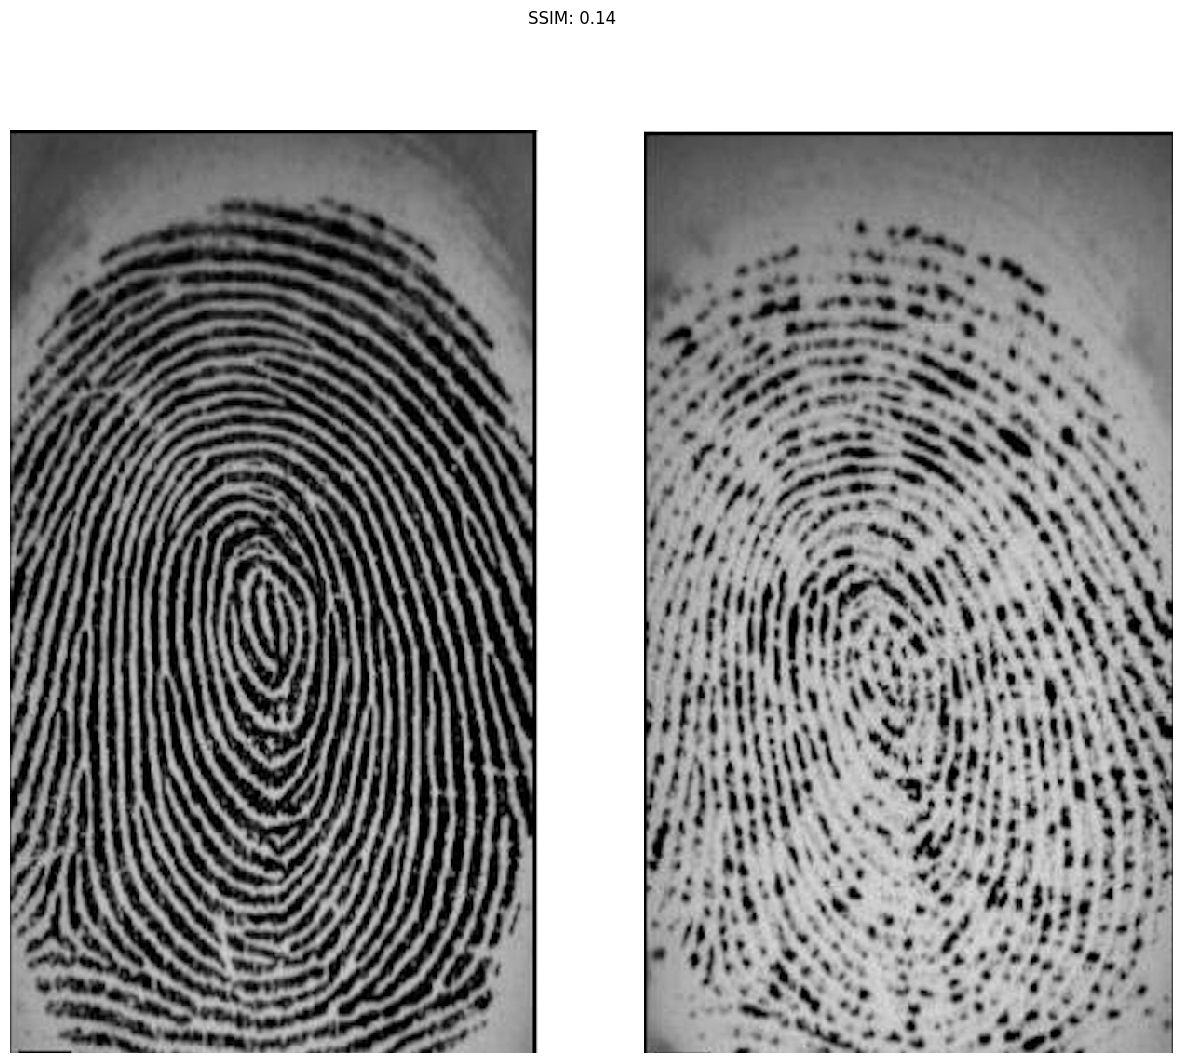

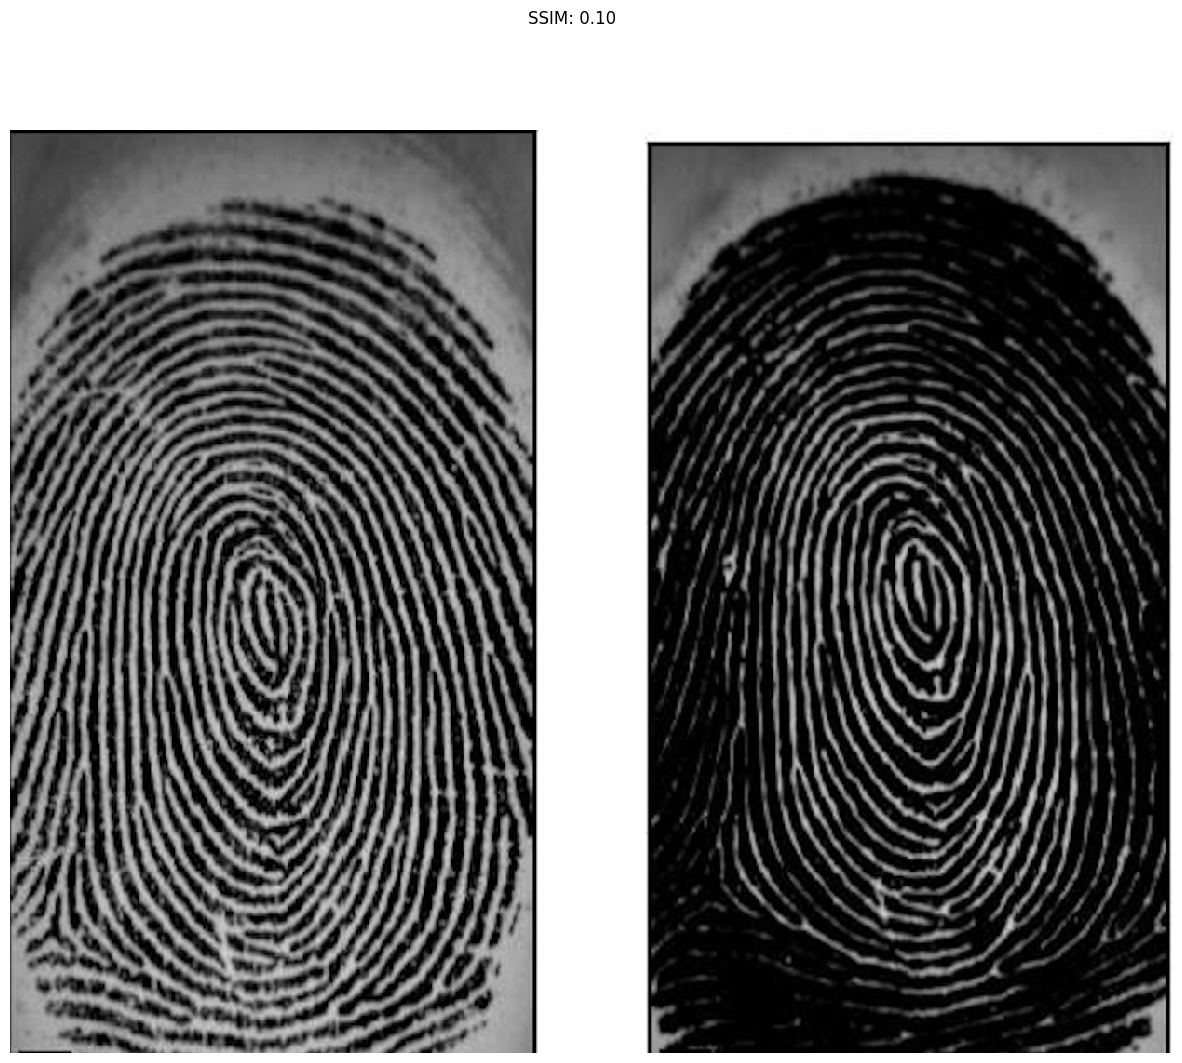

In [22]:
# initialize the figure
fig = plt.figure("Images")
images = ("Normal Fingerprint", normal), ("Dry Fingerprint", dry), ("Wet Fingerprint", wet)

# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image
	ax = fig.add_subplot(1, 3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
    
# show the figure
plt.show()

# compare the images
compare_images(normal, normal, "Normal Fingerprint vs. Normal Fingerprint")
compare_images(normal, dry, "Normal Fingerprint vs. Dry Fingerprint")
compare_images(normal, wet, "Normal Fingerprint vs. Wet Fingerprint")

#### Validating with Edge Detected Fingerprint

In [23]:
from utils import compare_images

# load the images -- the reference edges, dry edges, wet edges
normal_edges = cv2.imread("normal_edges.png")
dry_edges = cv2.imread("dry_edges.png")
wet_edges = cv2.imread("wet_edges.png")

# convert the images to grayscale
normal_edges = cv2.cvtColor(normal_edges, cv2.COLOR_BGR2GRAY)
dry_edges = cv2.cvtColor(dry_edges, cv2.COLOR_BGR2GRAY)
wet_edges = cv2.cvtColor(wet_edges, cv2.COLOR_BGR2GRAY)

# resize the images to be the same size as reference image
width, height = int(normal_edges.shape[1]), int(normal_edges.shape[0])
dry_edges = cv2.resize(dry_edges, (width, height)) 
wet_edges = cv2.resize(wet_edges, (width, height)) 

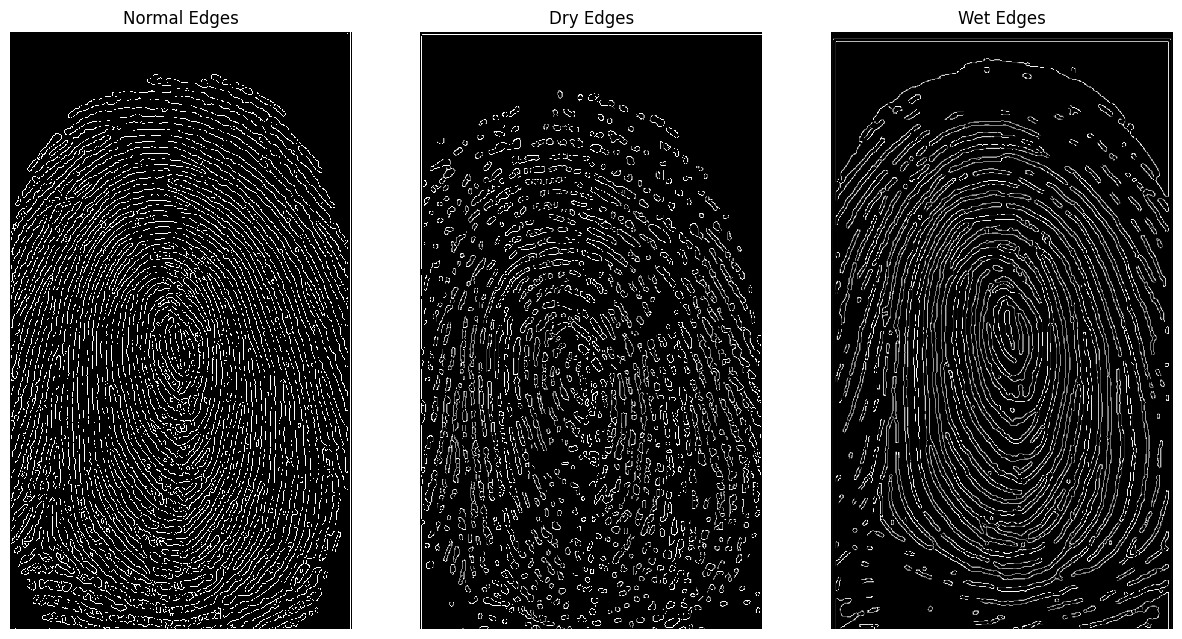

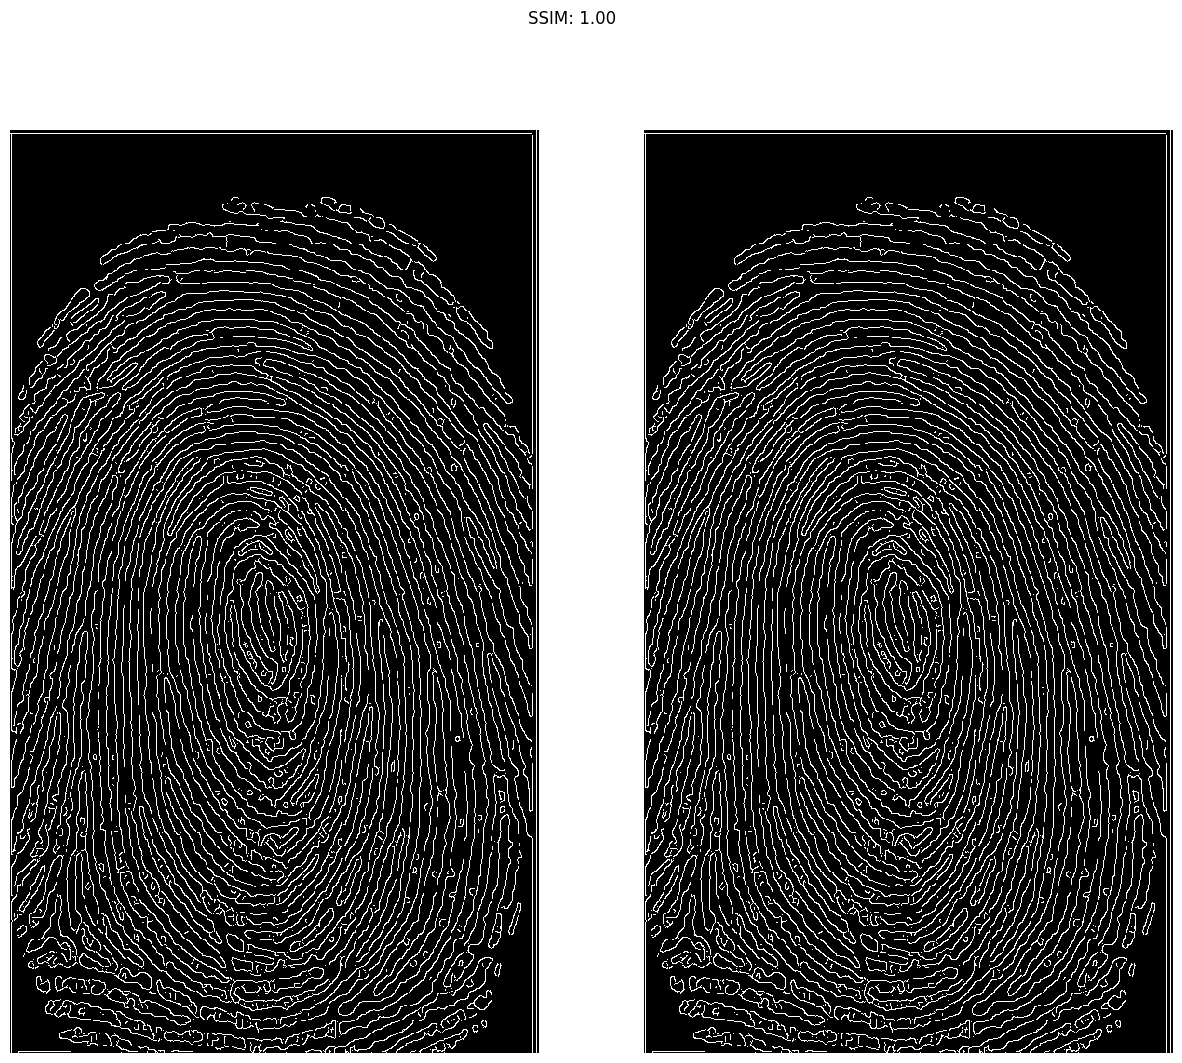

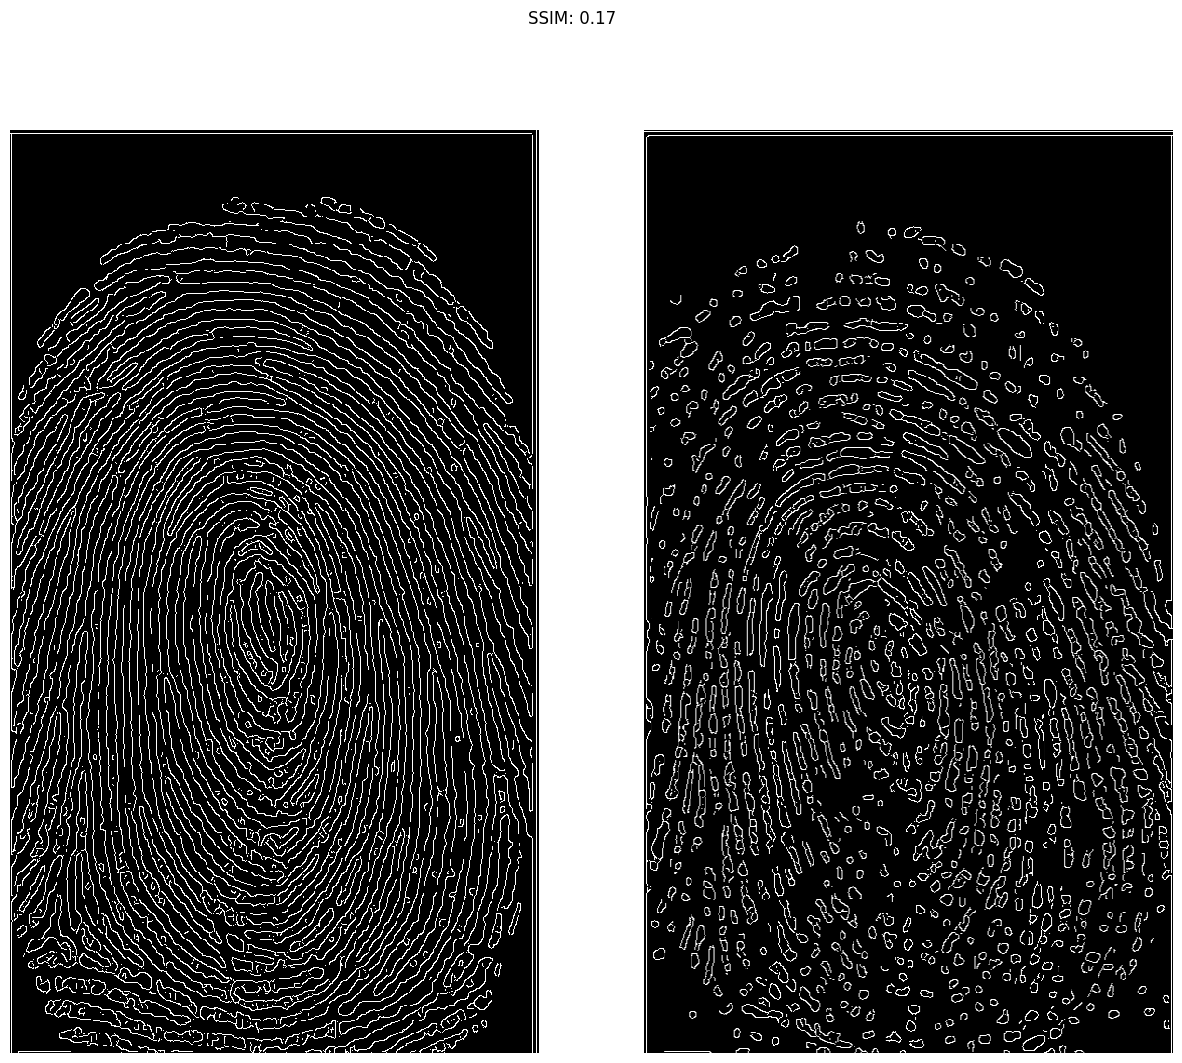

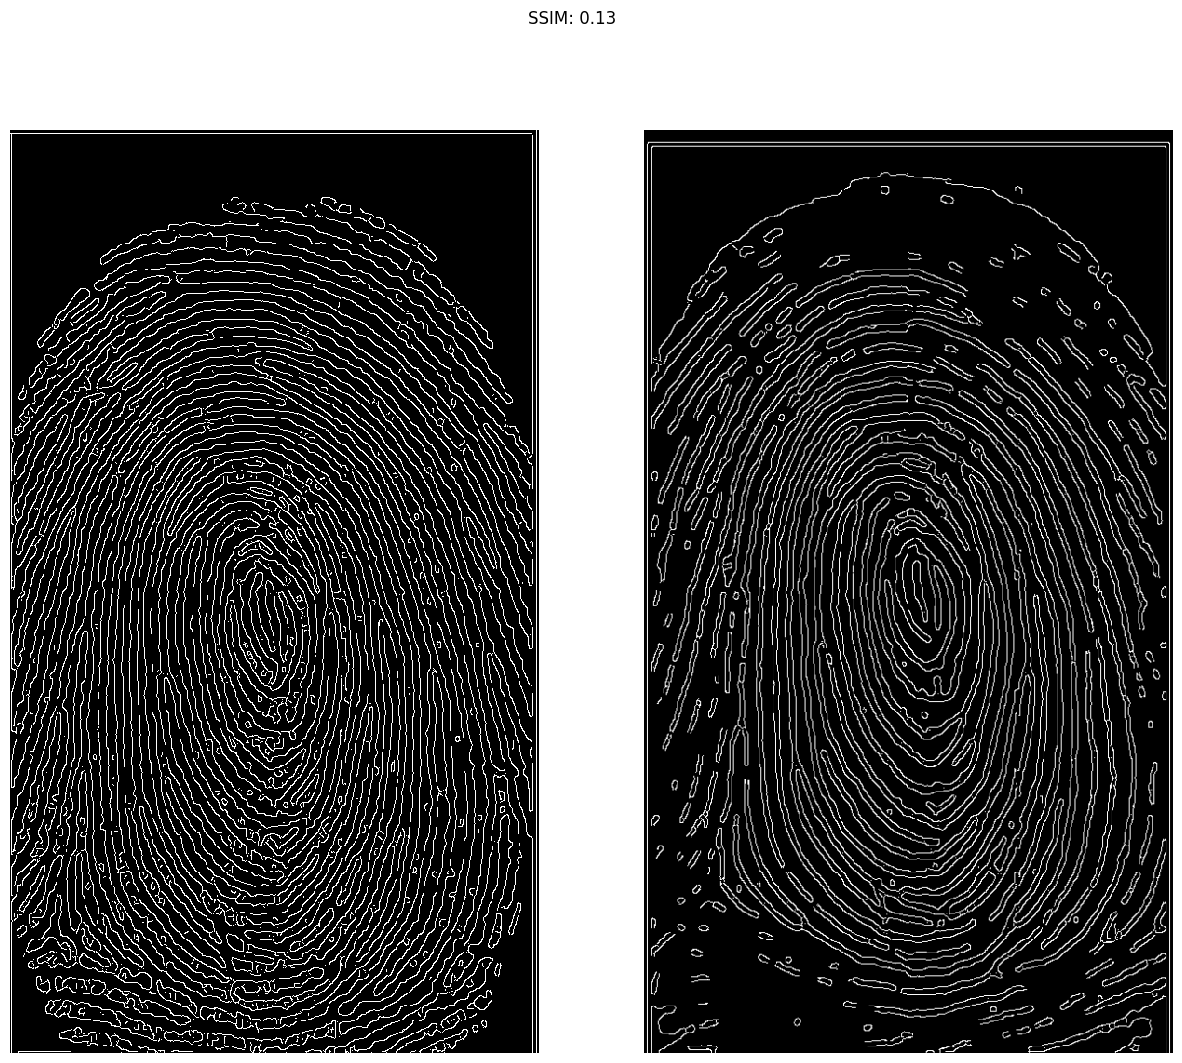

In [24]:
# initialize the figure
fig = plt.figure("Images")
images = ("Normal Edges", normal_edges), ("Dry Edges", dry_edges), ("Wet Edges", wet_edges)

# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image
	ax = fig.add_subplot(1, 3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
    
# show the figure
plt.show()

# compare the images
compare_images(normal_edges, normal_edges, "Normal Edges vs. Normal Edges")
compare_images(normal_edges, dry_edges, "Normal Edges vs. Dry Edges")
compare_images(normal_edges, wet_edges, "Normal Edges vs. Wet Edges")

#### Validating with Optimized Edge Detected Fingerprint

In [48]:
from utils import compare_images

# load the images -- the reference edges, dry edges, wet edges
normal_edges = cv2.imread("normal_edges.png")
dry_edges_optimized = cv2.imread("dry_edges_optimized.png")
wet_edges_optimized = cv2.imread("wet_edges_optimized.png")

# convert the images to grayscale
normal_edges = cv2.cvtColor(normal_edges, cv2.COLOR_BGR2GRAY)
dry_edges_optimized = cv2.cvtColor(dry_edges_optimized, cv2.COLOR_BGR2GRAY)
wet_edges_optimized = cv2.cvtColor(wet_edges_optimized, cv2.COLOR_BGR2GRAY)

# resize the images to be the same size as reference image
width, height = int(normal_edges.shape[1]), int(normal_edges.shape[0])
dry_edges_optimized = cv2.resize(dry_edges_optimized, (width, height)) 
wet_edges_optimized = cv2.resize(wet_edges_optimized, (width, height)) 

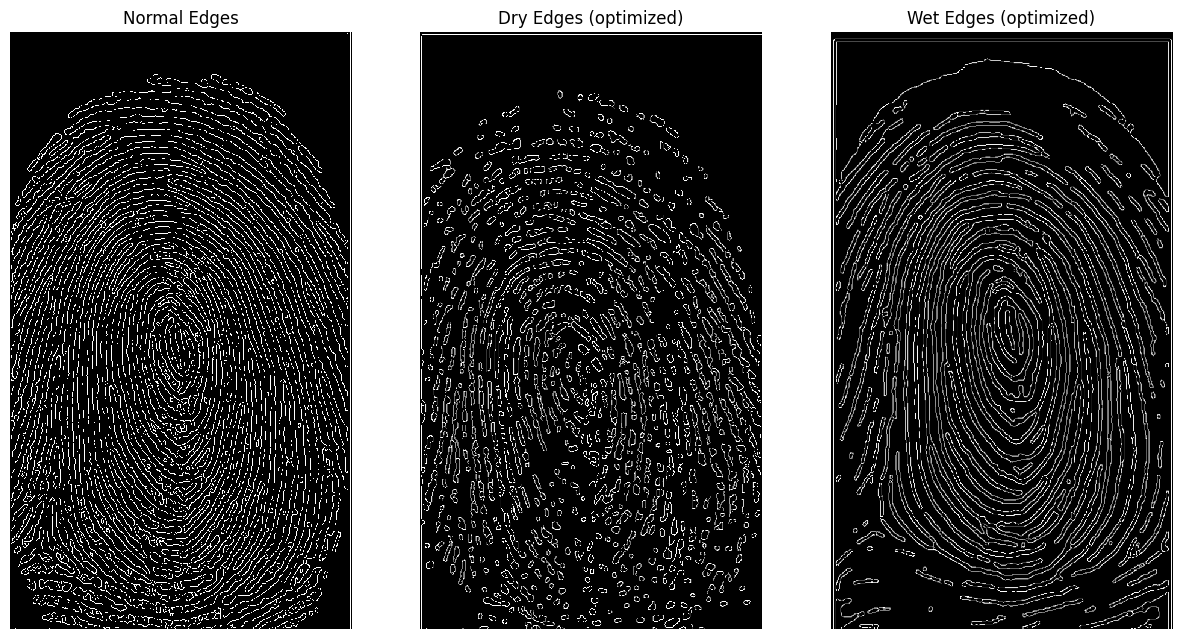

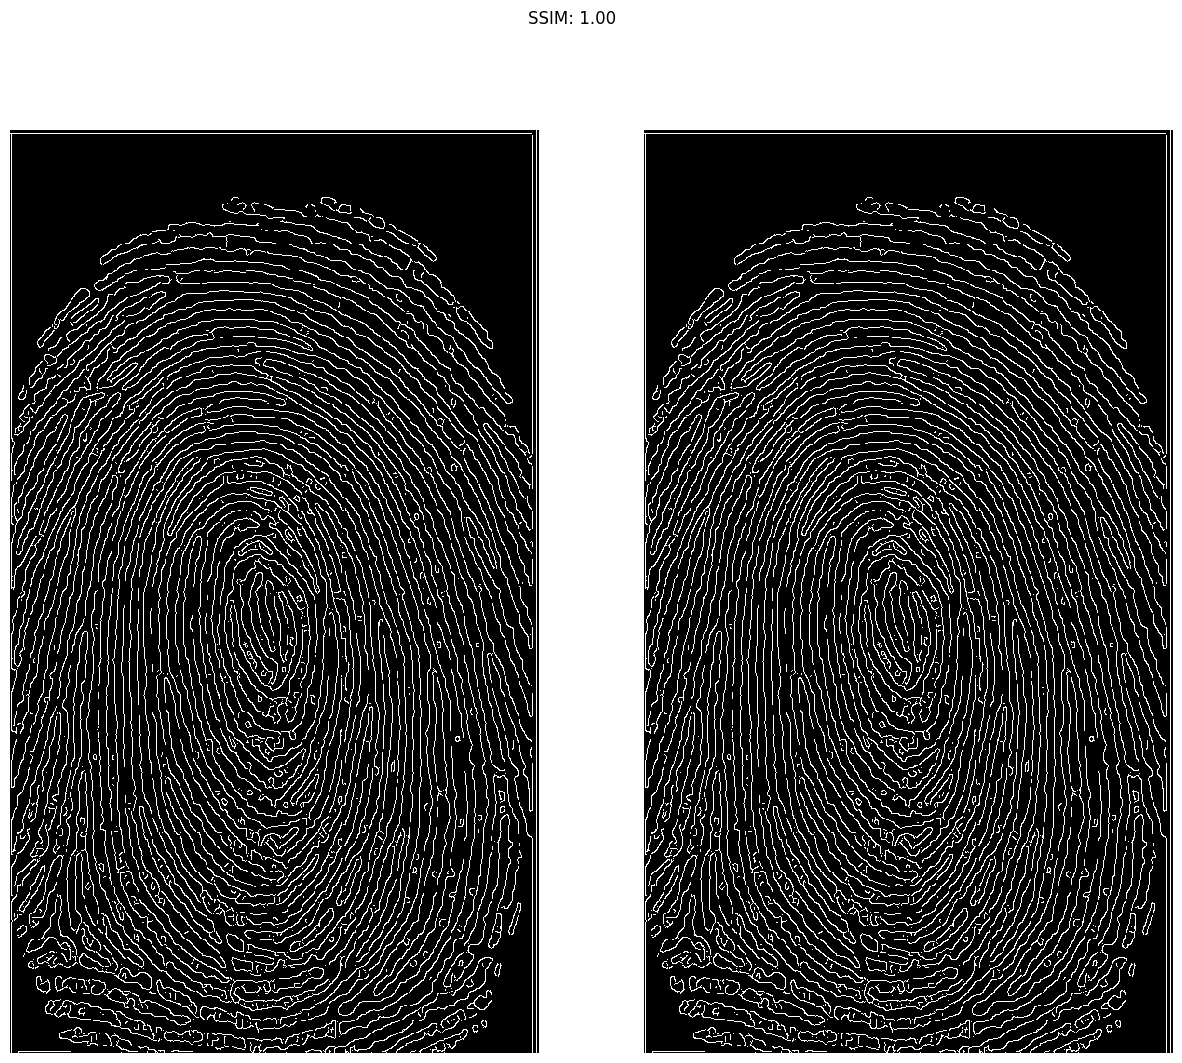

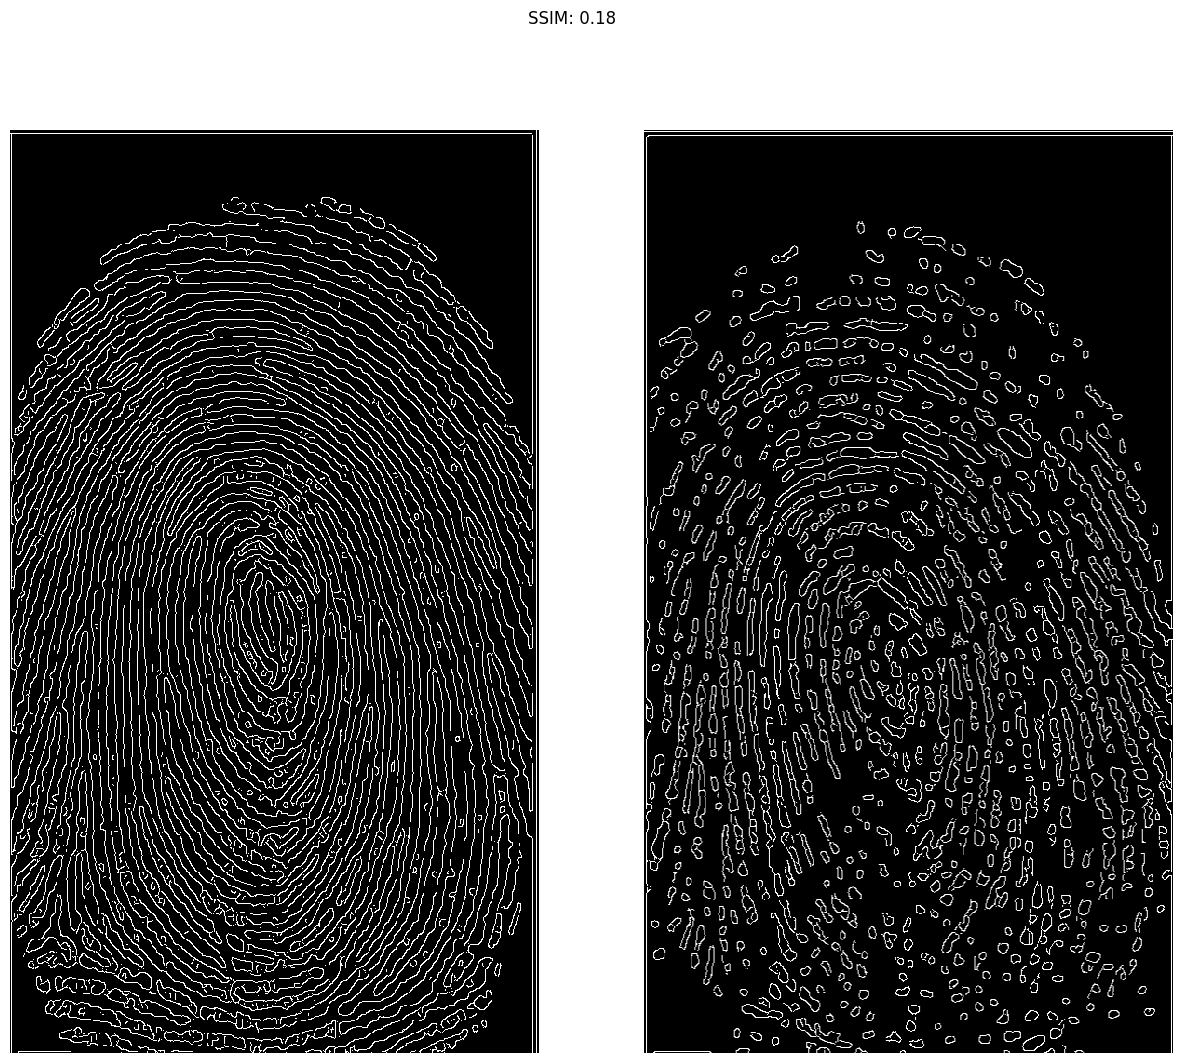

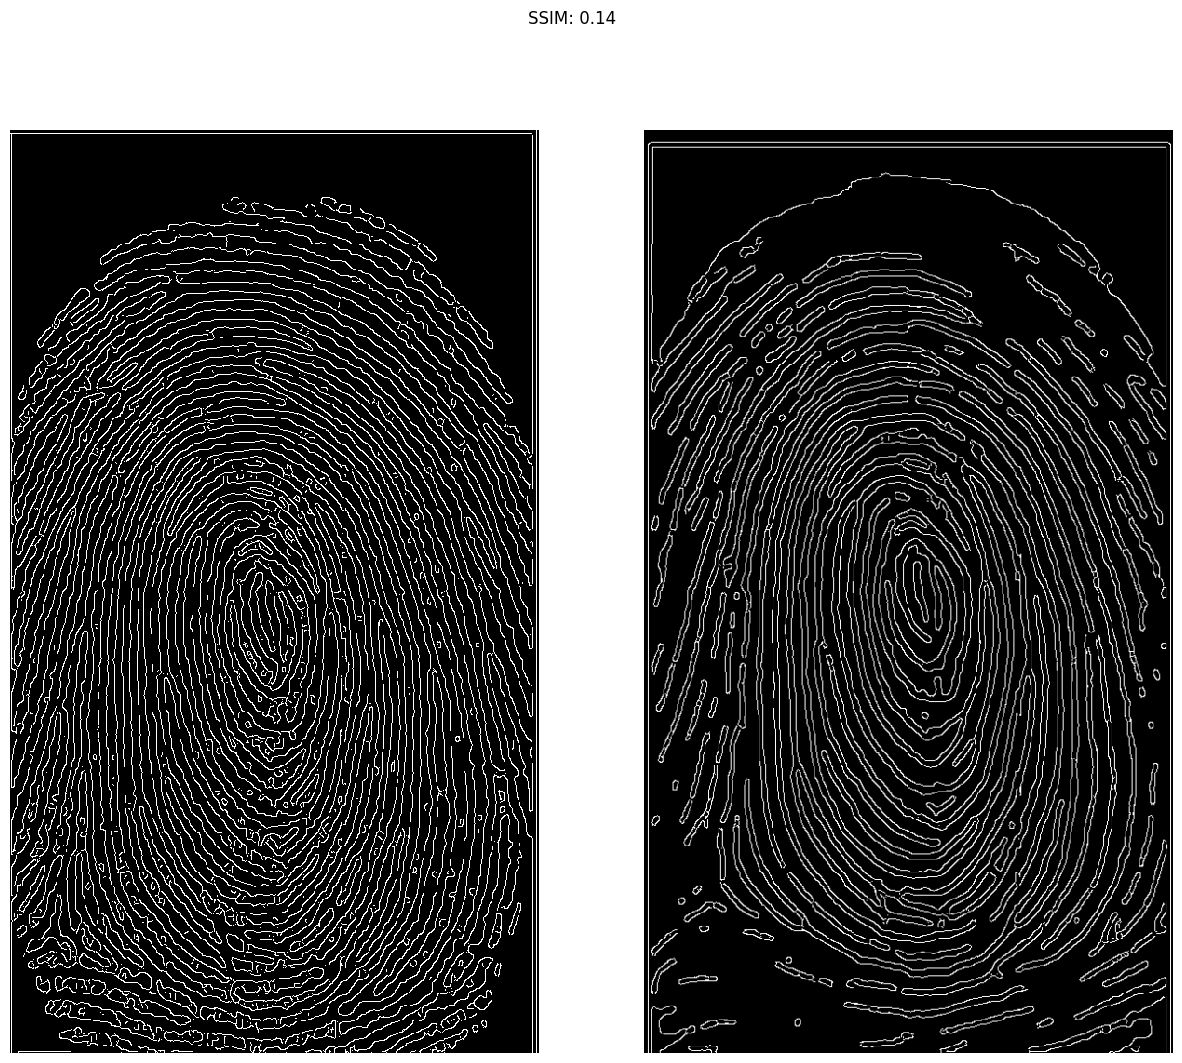

In [49]:
# initialize the figure
fig = plt.figure("Images")
images = ("Normal Edges", normal_edges), ("Dry Edges (optimized)", dry_edges_optimized), ("Wet Edges (optimized)", wet_edges_optimized)

# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image
	ax = fig.add_subplot(1, 3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
    
# show the figure
plt.show()

# compare the images
compare_images(normal_edges, normal_edges, "Normal Edges vs. Normal Edges")
compare_images(normal_edges, dry_edges_optimized, "Normal Edges vs. Dry Edges (optimized)")
compare_images(normal_edges, wet_edges_optimized, "Normal Edges vs. Wet Edges (optimized)")

### Conclusion

We observed the following similarity scores for the following comparisons:

- Normal Fingerprint to Normal Fingerprint: 1.00
- Normal Edges to Normal Edges: 1.00
-------------------------------------------------
- Normal Fingerprint to Dry Fingerprint: 0.14
- Normal Edges to Dry Edges: 0.17
- Normal Edges to Dry Edges (optimized): 0.18
-------------------------------------------------
- Normal Fingerprint to Wet Fingerprint: 0.10
- Normal Edges to Wet Edges: 0.13
- Normal Edges to Wet Edges (optimized): 0.14

While the similarity scores for the edge-detected fingeprint validations are still much lower than feasible for a robust fingeprint validator, there seems to be an overall 3% increase in similarity across fingerprint conditions from using Canny Edge Detection. Additrionally, with hyperparameter optimization, I was able to achieve an additional 1% simimlarity score increase, for a total of 4% increase in both fingerprint conditions. This leads me to believe that with proper image centering and normalizing, along with a more optimized similarity algorithm that accounts for image patterns on top of comparing local features, edge detection for fingerprint validation has the potential to be useful in cases of varying fingerprint conditions. 